### Make Quadrupole Field

In [1]:
from TestModules import *
from MMTModules import *
import numpy as np
import matplotlib.pyplot as plt

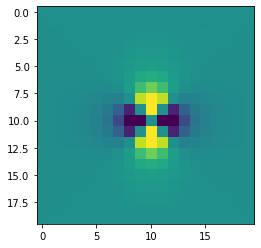

In [2]:

N = 1024
beam_map = np.zeros((N,N))
rotation_angle = np.pi/4

beam_map = quadrupole_field(beam_map, 10., rotation_angle=rotation_angle)
#beam_map = beam_map

vmin = -1
vmax = 1
eta = 0.00001
plt.imshow(beam_map[502:522,502:522],vmin=vmin,vmax=vmax)
plt.show()

### Store Fields in Beam Matrix and Show for pure T sky

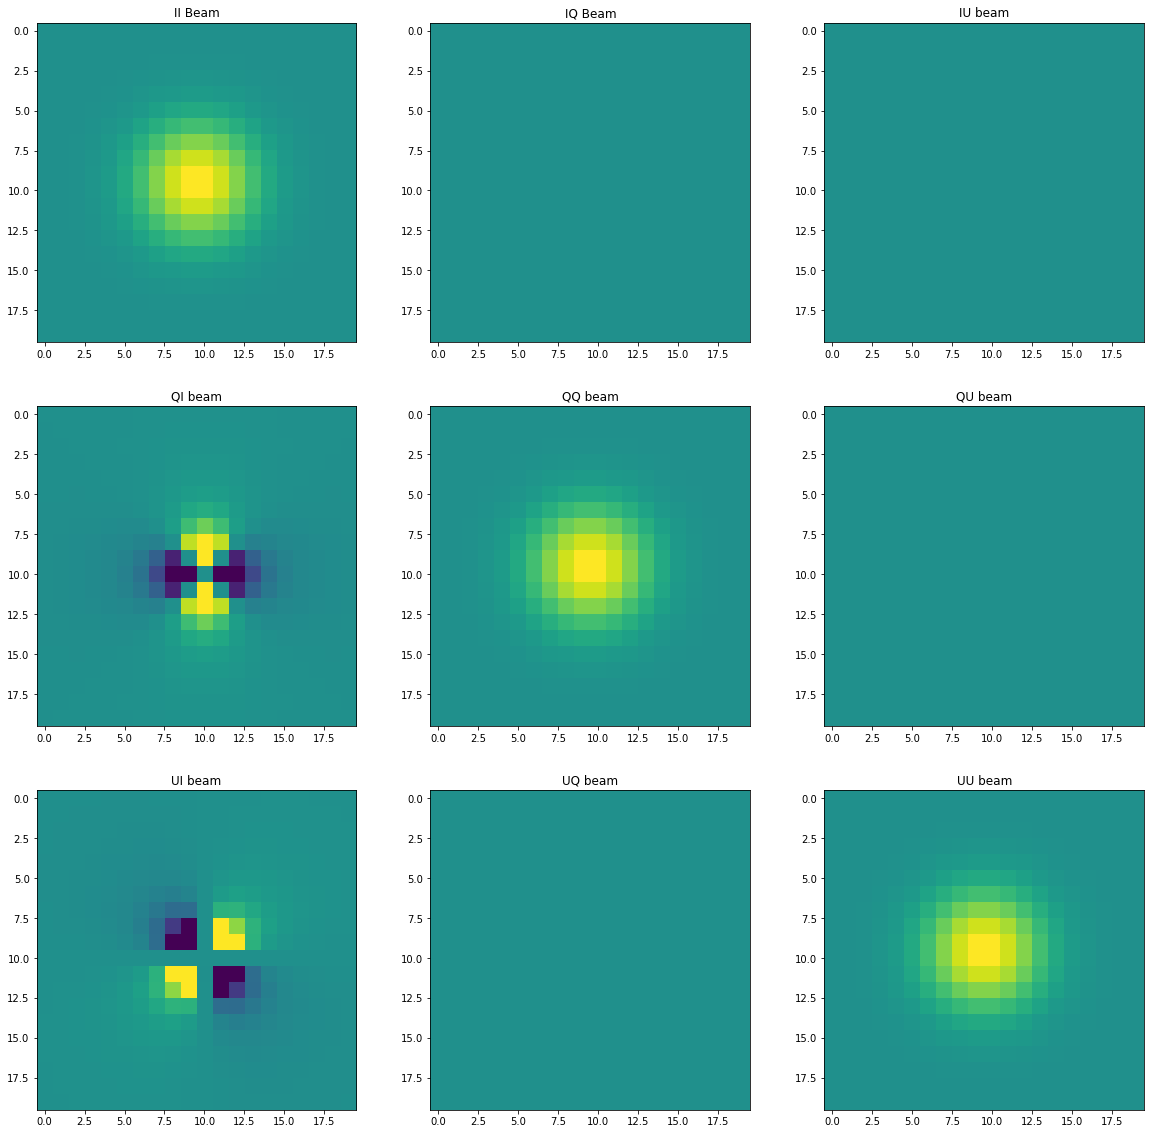

In [3]:
#rotation_angle for dipole is 0 for y-axis, pi/4 for b-axis, pi/2 for x-axis, -pi/4 for a-axis
#rotation_angle for quadrupole is 0 for U-axes and pi/4 for Q-axis

#interface
N=1024
pixel_size = 0.25/60.
inst_beam_width = 1.5
p = 10.
Q = 10.
delta_ell = 50.
ell_max = 5000    #maximum ell of Fourier Transform
pix_size = pixel_size*60.    #pixel size for Fourier Transform in arcmin
beam_map = np.zeros((N,N))
empty_map = np.zeros((N,N))
choose_normalization = 'TT'

#T is gaussian
inst_beam_1 = offset_2d_gaussian_beam(N, pix_size, inst_beam_width, 0,0)

#Q is dipole
#dipole_beam_Q  = 0.02*inst_beam_1
dipole_beam_Q = 0.02*quadrupole_field(beam_map, p, rotation_angle=np.pi/4)

#U is dipole
#dipole_beam_U = 0.02*inst_beam_1
dipole_beam_U = 0.02*quadrupole_field(beam_map, p, rotation_angle=0)

#############################################Plot Beam Matrix##############################################################

beam_matrix = {}
beam_matrix['II'] = inst_beam_1
beam_matrix['IQ'] = empty_map
beam_matrix['IU'] = empty_map
beam_matrix['QI'] = dipole_beam_Q
beam_matrix['QQ'] = inst_beam_1
beam_matrix['QU'] = empty_map
beam_matrix['UI'] = dipole_beam_U
beam_matrix['UQ'] = empty_map
beam_matrix['UU'] = inst_beam_1

#Plot beam maps in 3x3 matrix
fig, ax = plt.subplots(3,3, figsize=(20,20))
vmin = -1
vmax = 1

#II
ax[0,0].imshow(beam_matrix['II'][502:522,502:522],vmin=vmin,vmax=vmax)
ax[0,0].set_title('II Beam')

#IQ
ax[0,1].imshow(beam_matrix['IQ'][502:522,502:522],vmin=vmin,vmax=vmax)
ax[0,1].set_title('IQ Beam')

#IU
ax[0,2].imshow(beam_matrix['IU'][502:522,502:522],vmin=vmin,vmax=vmax)
ax[0,2].set_title('IU beam')

#QI
ax[1,0].imshow(beam_matrix['QI'][502:522,502:522],vmin=0.02*vmin,vmax=0.02*vmax)
ax[1,0].set_title('QI beam')

#QQ
ax[1,1].imshow(beam_matrix['QQ'][502:522,502:522],vmin=vmin,vmax=vmax)
ax[1,1].set_title('QQ beam')

#QU
ax[1,2].imshow(beam_matrix['QU'][502:522,502:522],vmin=vmin,vmax=vmax)
ax[1,2].set_title('QU beam')

#UI
ax[2,0].imshow(beam_matrix['UI'][502:522,502:522],vmin=0.02*vmin,vmax=0.02*vmax)
ax[2,0].set_title('UI beam')

#UQ
ax[2,1].imshow(beam_matrix['UQ'][502:522,502:522],vmin=vmin,vmax=vmax)
ax[2,1].set_title('UQ beam')

#UU
ax[2,2].imshow(beam_matrix['UU'][502:522,502:522],vmin=vmin,vmax=vmax)
ax[2,2].set_title('UU beam')
plt.show()

In [4]:
beam_matrix['II'][512,512]

1.0

### Calculate the TFs for a pure T sky

In [5]:
###########################################################################################################################


#Generate 2D power spectra from beam maps
Imap = inst_beam_1
Qmap = dipole_beam_Q
Umap = dipole_beam_U
binned_spectra_dict = calculate_2d_spectra(Imap=Imap, Qmap=Qmap, Umap=Umap, delta_ell=delta_ell, ell_max=ell_max, pix_size=pix_size, N=N)
beam_spectrum = calculate_2d_spectra(Imap=inst_beam_1, delta_ell=delta_ell, ell_max=ell_max, pix_size=pix_size, N=N)


sky_decomp = [1,0,0]
beam_fwhm = inst_beam_width


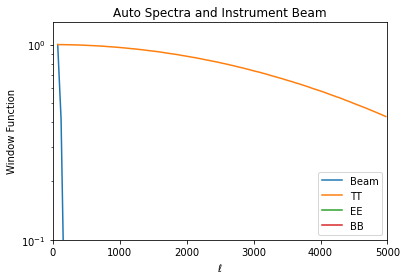

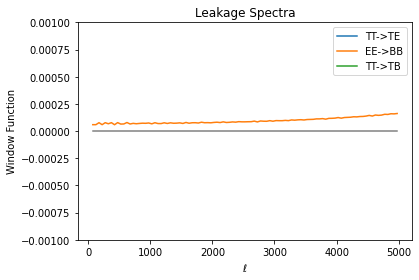

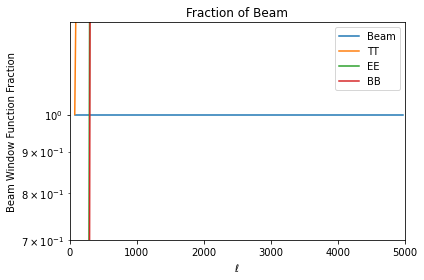

In [6]:
#combine to detector IQU array maps and make 2d FFTs and bin to 1d leakage spectra
binned_ell, binned_spectra = get_leakage_spectra(beam_matrix, pixel_size, N, inst_beam_width, sky_decomp, delta_ell, ell_max, choose_normalization)

### Zoom in

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


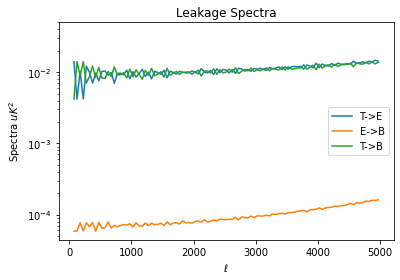

In [10]:
zero_line = np.zeros(len(binned_spectra['TE']))
ell_convert = binned_ell[1:]*(binned_ell[1:] + 1)/(2*np.pi)
plt.semilogy( binned_ell[1:], binned_spectra['TE'])#/(norm_fac*binned_spectra_dict['TT']) )
plt.semilogy(binned_ell[1:], binned_spectra['EB'])#/(norm_fac*binned_spectra_dict['EE']) )
plt.semilogy(binned_ell[1:], binned_spectra['TB'])#/(norm_fac*binned_spectra_dict['TT']))
plt.semilogy(binned_ell[1:], zero_line, color='gray')
cross_labels = ['T->E','E->B','T->B']
plt.legend(cross_labels)
plt.title('Leakage Spectra')
plt.ylabel('Spectra $uK^2$')
plt.xlabel('$\ell$')
plt.ylim(0,5e-2)
plt.show()

### Run Quadrupole Through Cobaya Central Value Shift:

Questions:

1.) Is the offset when using pure unbiased fiducial spectra from the gaussian likelihood approximation

2.) Should I do anything about 1.)?

3.) How should I weight the points?


Going to define the leakage TF TE as the measured TE and run through simulator, calling EE zero and TT is the LCDM fiducial spectrum

Assumptions:

1.) gaussian likelihood

2.) full sky survey

#### First fit the TFs to a Polynomial

Text(0, 0.5, 'Transfer Function')

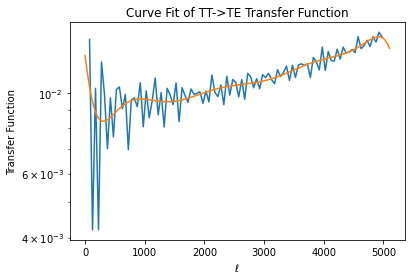

In [11]:
#define 9th order polynomial
def polynomial_9(x, a, b, c, d, e, f, g, h, i, j):
    return a*x**9. + b*x**8. + c*x**7. + d*x**6. + e*x**5. + f*x**4. + g*x**3. + h*x**2. + i*x + j

#For TE
import scipy.optimize as optimization

#ell_set is the range of ell values the binned spectrum goes over
ell_set = binned_ell[1:]
initial_guess = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

#right now for one simulation just take the std of the dataset. If it's necessary, multiple simulations can be run
#to make the weighting in the optimization more accurate, but for now I don't care as much
sigma = np.sqrt(np.var(binned_spectra['TE']))
errors = sigma*np.ones(len(binned_spectra['TE']))
curve_fit = optimization.curve_fit(polynomial_9, ell_set, binned_spectra['TE'], initial_guess, errors)

parameters = curve_fit[0]
ell = np.arange(ell_max+101)
tf_fit = polynomial_9(ell,parameters[0],parameters[1],parameters[2],
                      parameters[3],parameters[4],parameters[5],
                      parameters[6],parameters[7],parameters[8],parameters[9])
plt.semilogy(binned_ell[1:],binned_spectra['TE'])
plt.semilogy(ell,tf_fit)
plt.title('Curve Fit of TT->TE Transfer Function')
plt.xlabel('$\ell$')
plt.ylabel('Transfer Function')

### Define Simulation Parameters and Gaussian Likelihood

measured spectra with TE leakage (dividing out the beam), for pure fiducial sky

TT = TT

TE = TE + leakage*TT

EE = EE

leakage = (TT->TE)/beam

In [20]:
from CobayaModules import *
import numpy as np

#parameters
lmax = 5100    #for accuracy to lmax of 5000
packages_path = '/path/to/your/packages'
ell = np.arange(lmax+1)

#Define transfer functions
#TF_eff_dict = {}
#TF_eff_dict['TE'] = tf_fit[10:]
TF_eff_dict = None

#calculate fiducial spectra
Cl_fid = generate_fiducial(lmax = lmax)

#Define leakage spectrum as measured spectrum and assume the sky is pure T
Cl_fid['TE'] = Cl_fid['TE'] + Cl_fid['TT']*tf_fit[10:lmax+1]
Cl_fid['EE'] = Cl_fid['EE']

#parameter initialization
As_lower = 1e-9
As_upper = 4e-9
As_fid = 2.2e-9

ns_lower = 0.9
ns_upper = 1.1
ns_fid = 0.96

nnu_lower = 3.03
nnu_upper = 3.06
nnu_fid = 3.046

#define gaussian likelihood
#including TT, TE, EE in likelihood
def my_like_multi_spectra(
        # Parameters that we may sample over (or not)
        Cl_fid=Cl_fid,
        #TF_eff = TF_mag[8:l_max-1],
        TF_eff_dict = TF_eff_dict,
        # Keyword through which the cobaya likelihood instance will be passed.
        _self=None):
    import numpy as np
    
    # Cl of the map: data + noise
    Cl_map = {}
    if TF_eff_dict is not None:
        Cl_map = Cl_fid
        for tf_key in TF_eff_dict.keys():
            if tf_key is 'TT':
                Cl_map['TT'] = TF_eff_dict['TT']*Cl_fid['TT']
            elif tf_key is 'TE':
                Cl_map['TE'] = TF_eff_dict['TE']*Cl_fid['TE']
            elif tf_key is 'EE':
                Cl_map['EE'] = TF_eff_dict['EE']*Cl_fid['EE']
            else:
                print(str(tf_key) + ' spectrum not included')
    else:
        Cl_map = Cl_fid
    
    # Request the Cl from the provider
    # I believe what this is is a snapshot of what the theoretical spectrum is at that particular set of sampled LCDM model
    Cl_theo_tt = _self.provider.get_Cl(ell_factor=False, units="muK2")['tt'][10:lmax+1]
    Cl_theo_ee = _self.provider.get_Cl(ell_factor=False, units="muK2")['ee'][10:lmax+1]
    Cl_theo_te = _self.provider.get_Cl(ell_factor=False, units="muK2")['te'][10:lmax+1]
    
    #Cl_map['TT'] = Cl_theo_tt
    #Cl_map['EE'] = Cl_theo_ee
    #Cl_map['TE'] = Cl_theo_te
    
    Cl_map_theo = {}
    Cl_map_theo['TT'] = Cl_theo_tt
    Cl_map_theo['EE'] = Cl_theo_ee
    Cl_map_theo['TE'] = Cl_theo_te
    
    #covariance matrix is the inverse of the wishart curvature
    Cov_inv = np.asarray( ( (2*ell[8:lmax-1]+1) ) / ( 2*(Cl_map['TT']*Cl_map['EE'] - Cl_map['TE']**2.)**2. ) * [[Cl_map['EE']**2., -2*Cl_map['TE']*Cl_map['EE'], Cl_map['TE']**2.],
       [-2*Cl_map['EE']*Cl_map['TE'], 2*(Cl_map['TT']*Cl_map['EE']+Cl_map['TE']**2.), -2*Cl_map['TT']*Cl_map['TE']],
      [Cl_map['TE']**2., -2*Cl_map['TE']*Cl_map['TT'],Cl_map['TT']**2.]])
    
    #approximating the likelihood as gaussian
    d = np.asarray([Cl_map['TT'], Cl_map['TE'], Cl_map['EE']])
    m = np.asarray([Cl_map_theo['TT'], Cl_map_theo['TE'], Cl_map_theo['EE']])
    curv = np.asarray([np.sum(Cov_inv[0,0]*(d-m)[0])+np.sum(Cov_inv[0,1]*(d-m)[1])+np.sum(Cov_inv[0,2]*(d-m)[2]), 
                   np.sum(Cov_inv[1,0]*(d-m)[0])+np.sum(Cov_inv[1,1]*(d-m)[1])+np.sum(Cov_inv[1,2]*(d-m)[2]), 
                   np.sum(Cov_inv[2,0]*(d-m)[0])+np.sum(Cov_inv[2,1]*(d-m)[1])+np.sum(Cov_inv[2,2]*(d-m)[2])])
    
    logp = ( np.matmul(np.transpose(np.sum(d-m,axis=1)), curv) )
            
    # Set our derived parameter
    derived = {'Map_Cl_at_500': Cl_map['TT'][500]}
    return logp, derived

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!


### Finalize Simulation and Calculate the Shift in $N_\nu$

In [22]:

#use above leakage spectra calculation (TE,TB,EB) to bias fiducial spectra
#TF_TE = binned_spectra['TE']
#TF_TB = binned_spectra['TB']
#TF_EB = binned_spectra['EB']

#initialize
#info = initialize_simulation(Nl=None, TF_eff=None, As_lower=1e-9, As_upper=4e-9, As_fid = 2.2e-9, ns_lower=0.9, ns_upper=1.1, ns_fid=0.96, nnu_lower=3.04, nnu_upper=3.05, nnu_fid=3.046)

info = {
        'params': {
            # Fixed
            'ombh2': 0.022, 'omch2': 0.12, 'H0': 68, 'tau': 0.07,
            'mnu': 0.06,
            # Sampled
            'As': {'prior': {'min': As_lower, 'max': As_upper}, 'latex': 'A_s'},
            'ns': {'prior': {'min': ns_lower, 'max': ns_upper}, 'latex': 'n_s'},
            'nnu': {'prior': {'min': nnu_lower, 'max': nnu_upper}, 'latex': 'nnu'},
            # Derived
            'Map_Cl_at_500': {'latex': r'C_{500,\,\mathrm{map}}'}},
        'likelihood': {'my_cl_like': {
            "external": my_like_multi_spectra,
            # Declare required quantities!
            "requires": {'Cl': {'tt': lmax}},
            # Declare derived parameters!
            "output_params": ['Map_Cl_at_500']}},
        'theory': {'camb': {'stop_at_error': True}},
        'packages_path': packages_path}


#calculate
from cobaya.model import get_model
model = get_model(info)


#get shift
num_nnu_samples = 500
nnu_max_shift = calculate_shift(model, nnu_lower, nnu_upper, num_nnu_samples, nnu_fid, As_fid, ns_fid)



[camb] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[my_cl_like] Initialized external likelihood.
nnu has been shifted by 0.014000000000000234 by noise and systematics.
The new maximum liklihood is given by 3.06
